In [ ]:
!pip3 install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive # Import photos from Google Photos
from mtcnn.mtcnn import MTCNN # Facial detection
from keras.models import load_model # Load pretrained models into tf (transfer learning)
from PIL import Image # Image manipulation package
import numpy as np
import pandas as pd
# from pnslib import utils # Download certain feature detection models (eyes, mouths)
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, \
  Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization,  RandomRotation,  RandomFlip, \
  LeakyReLU, Dropout, Rescaling, Add, GlobalAveragePooling2D, MaxPooling2D, Concatenate, Activation, MaxPool2D, Convolution2D, LocallyConnected2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.losses import MSE, sparse_categorical_crossentropy, binary_crossentropy
from keras.applications.vgg16 import VGG16
from tensorflow import keras
import cv2

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#load dataset
lfw_people = fetch_lfw_people(min_faces_per_person=60)
n_samples, h, w = lfw_people.images.shape
img = lfw_people.images
t = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(n_classes, img.shape)

8 (1348, 62, 47)


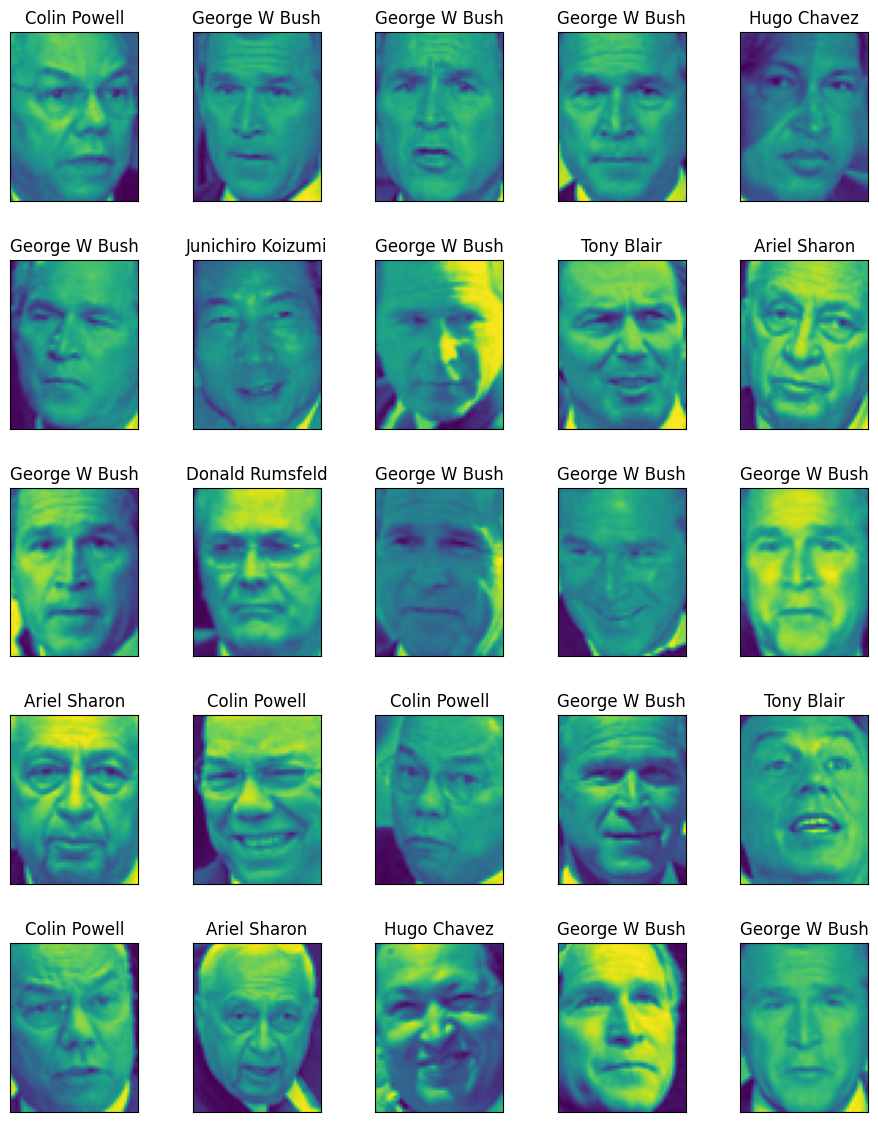

In [ ]:
def plot_faces(images, titles, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_faces(img, target_names[t], 5, 5)

In [ ]:
#define X and Y
X = lfw_people.images
y = lfw_people.target
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = y.reshape(X.shape[0], 1)
data_y = pd.DataFrame(y)
data_y.columns = ["Target"]
Y = pd.get_dummies(data_y["Target"], prefix='target')
y=np.array(Y)

print(X.shape)
print(y.shape)
numclass=y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

(1348, 62, 47, 1)
(1348, 8)


In [ ]:
#define the neural network architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='valid',input_shape=(62,47,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='valid'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='valid'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='valid'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(numclass, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
#Model fit of the training dataset
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
trained_model = model.fit(X_train, y_train, epochs=60, batch_size=100, verbose=1, validation_split=0.1,callbacks=[callback])

Epoch 1/60
10/10 [==============================] - 16s 1s/step - loss: 1.8757 - accuracy: 0.3828 - val_loss: 1.8962 - val_accuracy: 0.4020
Epoch 2/60
10/10 [==============================] - 4s 385ms/step - loss: 1.8234 - accuracy: 0.4015 - val_loss: 1.9017 - val_accuracy: 0.4020
Epoch 3/60
10/10 [==============================] - 4s 384ms/step - loss: 1.8467 - accuracy: 0.3982 - val_loss: 1.8947 - val_accuracy: 0.4020
Epoch 4/60
10/10 [==============================] - 6s 591ms/step - loss: 1.8248 - accuracy: 0.3993 - val_loss: 1.9174 - val_accuracy: 0.4020
Epoch 5/60
10/10 [==============================] - 6s 606ms/step - loss: 1.8107 - accuracy: 0.3982 - val_loss: 1.8821 - val_accuracy: 0.4020
Epoch 6/60
10/10 [==============================] - 7s 649ms/step - loss: 1.8031 - accuracy: 0.3993 - val_loss: 1.9102 - val_accuracy: 0.4020
Epoch 7/60
10/10 [==============================] - 6s 643ms/step - loss: 1.8169 - accuracy: 0.3993 - val_loss: 1.8811 - val_accuracy: 0.4020
Epoch 8/

In [ ]:
#save model
model.save("/content/gdrive/MyDrive/CV_Project/cnn_embed.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


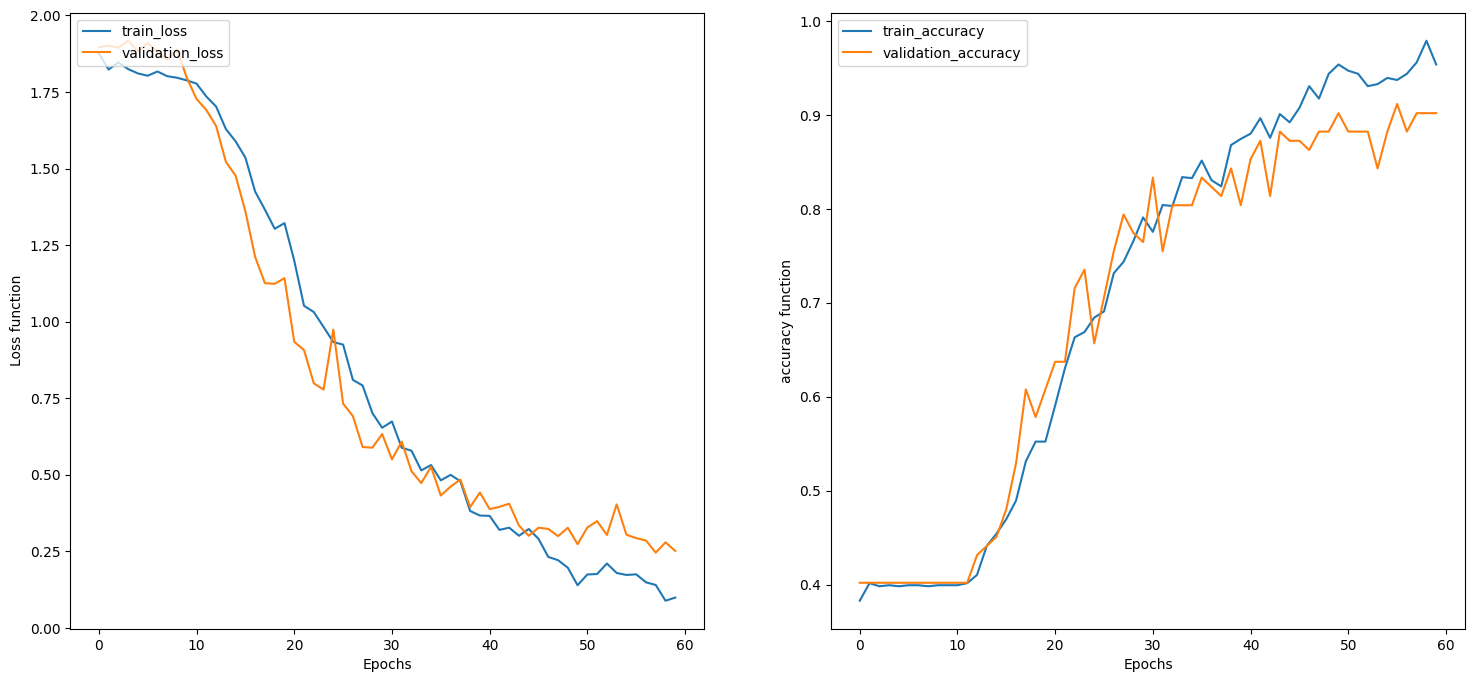

In [ ]:
#Plotting the resultant loss and the accuracy of the training and validation model
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(trained_model.history["loss"], label='train_loss')
plt.plot(trained_model.history["val_loss"], label='validation_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.plot(trained_model.history["accuracy"], label='train_accuracy')
plt.plot(trained_model.history["val_accuracy"], label='validation_accuracy')
plt.xlabel("Epochs")
plt.ylabel("accuracy function")
plt.legend(loc='upper left')
plt.show()

In [ ]:
#load the model
from keras.models import load_model

model = load_model("/content/gdrive/MyDrive/CV_Project/cnn_embed.h5")

In [ ]:
y_pred = model.predict(X_test)
print("The accuracy of the predicted value from the model:", (1-np.mean(np.abs(y_pred-y_test)))*100)
loss, accuracy = model.evaluate(X_test, y_test)
print("The loss value of the test dataset", loss)
print("The accuracy value of the test dataset:", accuracy*100)

11/11 [==============================] - 1s 39ms/step
The accuracy of the predicted value from the model: 97.18403611332178
11/11 [==============================] - 1s 42ms/step - loss: 0.3731 - accuracy: 0.9110
The loss value of the test dataset 0.3730608820915222
The accuracy value of the test dataset: 91.09792113304138


In [ ]:
y_test=np.argmax(y_test, axis=-1)
y_pred=np.argmax(y_pred, axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=lfw_people.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.77      0.67      0.71        15
     Colin Powell       0.96      0.96      0.96        68
  Donald Rumsfeld       0.81      0.81      0.81        31
    George W Bush       0.93      0.93      0.93       126
Gerhard Schroeder       0.84      0.91      0.87        23
      Hugo Chavez       0.85      0.85      0.85        20
Junichiro Koizumi       1.00      1.00      1.00        12
       Tony Blair       0.95      0.95      0.95        42

         accuracy                           0.91       337
        macro avg       0.89      0.88      0.89       337
     weighted avg       0.91      0.91      0.91       337



In [20]:
y_test,y_pred

(array([3, 4, 3, 6, 6, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 1, 7, 2, 3, 2, 7, 3,
        5, 5, 0, 3, 6, 7, 3, 3, 0, 6, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 7, 1,
        3, 3, 5, 1, 1, 2, 7, 3, 5, 6, 7, 3, 7, 1, 7, 0, 4, 2, 4, 2, 5, 4,
        7, 3, 4, 3, 1, 3, 4, 1, 3, 5, 0, 4, 3, 3, 3, 3, 1, 0, 3, 2, 3, 2,
        7, 1, 1, 3, 2, 7, 3, 1, 7, 3, 3, 3, 3, 7, 3, 4, 3, 3, 0, 3, 7, 3,
        3, 1, 0, 7, 7, 1, 3, 2, 7, 4, 7, 7, 5, 2, 3, 3, 3, 3, 3, 2, 3, 7,
        0, 3, 4, 3, 4, 1, 3, 3, 7, 6, 5, 3, 3, 1, 1, 3, 5, 4, 3, 2, 1, 1,
        7, 1, 3, 7, 1, 4, 6, 1, 1, 3, 2, 3, 1, 7, 0, 2, 1, 7, 1, 3, 1, 1,
        1, 3, 3, 1, 1, 4, 1, 1, 7, 1, 1, 5, 3, 3, 3, 3, 4, 5, 6, 3, 7, 3,
        3, 2, 0, 3, 2, 3, 3, 6, 3, 3, 1, 7, 3, 6, 1, 2, 3, 1, 1, 7, 4, 3,
        1, 1, 5, 7, 7, 2, 2, 7, 5, 7, 1, 3, 3, 7, 3, 4, 7, 4, 3, 1, 3, 4,
        5, 1, 4, 3, 2, 1, 5, 3, 2, 3, 4, 1, 1, 1, 0, 2, 3, 7, 3, 7, 3, 7,
        3, 1, 3, 1, 3, 2, 1, 1, 3, 3, 1, 3, 4, 3, 1, 4, 1, 5, 0, 3, 2, 0,
        2, 5, 1, 3, 3, 6, 2, 2, 3, 6, 

In [22]:
def plot_matched_faces(images, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    i=0
    k=0
    t=[]
    while(k<6):
        plt.subplot(n_row, n_col, k + 1)
        if(titles[i] in t):
          i=i+1
          continue
        else:
          plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
          plt.title(titles[i], size=12)
          plt.xticks(())
          plt.yticks(())
          t.append(titles[i])
          k=k+1
        i=i+1

In [21]:
def pred(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


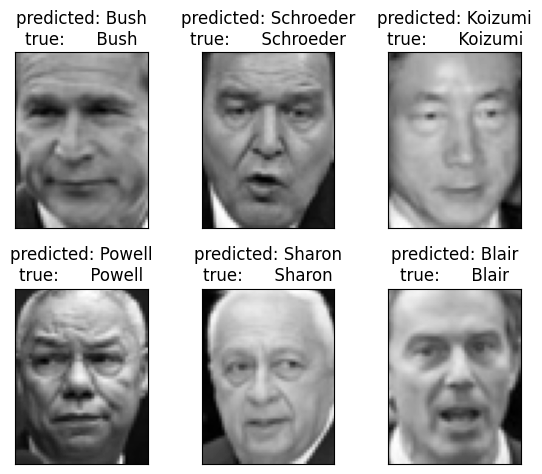

In [23]:
prediction_titles = [pred(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_matched_faces(X_test, prediction_titles, h, w)

plt.show()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 60, 45, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 22, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 22, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 20, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 20, 64)        0         
                                                        

In [25]:
intermediate_layer_name = 'conv2d_2'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(intermediate_layer_name).output)
embeddings = intermediate_layer_model.predict(X_test)


11/11 [==============================] - 1s 60ms/step


In [26]:
embeddings

array([[[[-6.57935679e-01, -8.03936869e-02, -2.55485624e-01, ...,
          -1.46213442e-01, -5.22456706e-01,  2.38800809e-01],
         [-6.11559212e-01, -1.25172632e-02, -3.04798454e-01, ...,
          -8.86324495e-02, -5.06013691e-01,  1.84478179e-01],
         [-4.91691411e-01, -1.71389140e-03, -2.98105985e-01, ...,
           4.96807210e-02, -4.38399941e-01,  4.26564179e-02],
         ...,
         [-4.98671234e-01,  6.52359352e-02, -2.60151029e-01, ...,
           2.21954267e-02, -4.63814020e-01, -3.12409438e-02],
         [-4.99652326e-01,  2.14401424e-01, -1.04518645e-01, ...,
          -1.03695609e-01, -5.25261223e-01, -1.19605511e-01],
         [-4.20390517e-01,  2.10264087e-01,  1.88411251e-02, ...,
          -1.76862940e-01, -4.59624946e-01, -1.30997524e-01]],

        [[-1.53687239e-01, -6.44568622e-01, -8.01719487e-01, ...,
           1.57908455e-01,  3.94183435e-02, -1.21245869e-02],
         [ 8.95980895e-02, -5.86378157e-01, -6.54943168e-01, ...,
          -2.90919840e

In [29]:
embeddings.shape,X_test.shape

((337, 12, 8, 128), (337, 62, 47, 1))

In [27]:
from numpy import savez_compressed

savez_compressed('lfw-70-dataset.npz',X_train,y_train,X_test,y_test)

In [30]:
from numpy import load, asarray

data = load('/content/lfw-70-dataset.npz')
trainx, testx = data['arr_0'],data['arr_2']
print(trainx.shape, testx.shape)
intermediate_layer_name = 'conv2d_2'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(intermediate_layer_name).output)
train_embeddings = asarray(intermediate_layer_model.predict(trainx))
test_embeddings = asarray(intermediate_layer_model.predict(testx))


#save the embeddings
#compress the 128 embeddings of each face
savez_compressed('lfw-embeddings_128.npz',train_embeddings,test_embeddings)

(1011, 62, 47, 1) (337, 62, 47, 1)
11/11 [==============================] - 1s 104ms/step


In [72]:
from sklearn.metrics.pairwise import cosine_similarity

In [92]:
test_idx = 225
test_embedding = test_embeddings[test_idx].reshape(1, -1)  # Reshape to a 2D array
distances = cosine_similarity(test_embedding, train_embeddings.reshape(len(train_embeddings), -1))
top5_indices = np.argsort(distances[0])[-5:][::-1]

In [76]:
data1 = load('/content/lfw-70-dataset.npz')
train_x,train_y,test_x,test_y = data1['arr_0'],data1['arr_1'], data1['arr_2'],data1['arr_3']

data = load('/content/lfw-embeddings_128.npz')
trainx,testx= data['arr_0'],data['arr_1']

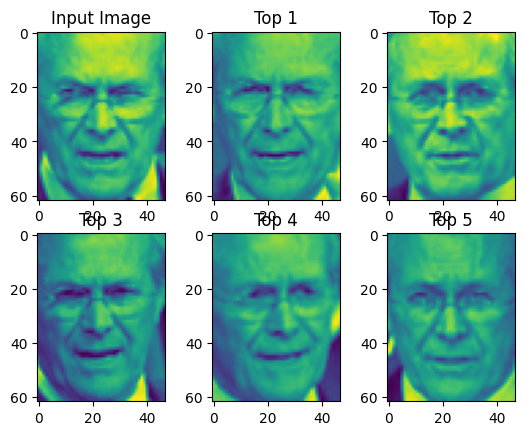

In [93]:
# Display the input image
plt.subplot(2, 3, 1)
plt.imshow(test_x[test_idx])
plt.title('Input Image')

# Display the top 5 closest match images
for i, index in enumerate(top5_indices):
    plt.subplot(2, 3, i + 2)
    plt.imshow(train_x[index])
    plt.title(f'Top {i + 1}')

plt.show()